## Importing Libraries

In [122]:
from pyspark.sql import SparkSession, functions, types
from bs4 import BeautifulSoup
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, CountVectorizerModel
from pyspark.ml import Pipeline
from pyspark.ml.clustering import LDA, LocalLDAModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

## Loading Data

### Loading Businesses Data

In [33]:
# read business json file
df_init_business = spark.read.json('business.json')

# filter only restaurants in Toronto
df_filter_business = df_init_business.where((functions.lower(df_init_business['categories']).contains('restaurant')) & (functions.lower(df_init_business['city']) == 'toronto'))

# select required columns
df_business = df_filter_business.select(df_filter_business['business_id'], df_filter_business['name'])

### Loading Reviews Data

In [34]:
# read reviews json file
df_init_review = spark.read.json('review.json')

# get only reviews for filtered businesses
df_business_reviews = df_business.join(df_init_review, 'business_id', 'left')

# filter reviews
df_filter_reviews = df_business_reviews.where(df_business_reviews['text'] != '')

# select required columns
df_reviews = df_business_reviews.select(df_business_reviews['review_id'], df_business_reviews['business_id'], functions.lower(df_business_reviews['text']).alias('review_text')) \
                .cache()

## Preprocessing Data

### One sample of review text before processing

In [36]:
df_reviews.take(1)[0][2]

"so i've never been to the shop, but i see this lady at the montgomery inn farmers market.  sometimes i get a scone or a butter tart and they are always delicious (earl grey and white chocolate scone... mmmm so good).\nso i have been having a craving for a slice of cherry pie since my birthday (beginning of feb).  i'm not gonna lie, i was imagining the overly sweet sugar coated crust with canned filling... not sure why?  so, last week i'm going in for my scone when what do i see.... a mini cherry pie!  at $7 i'm thinking what a steal to fulfill my birthday dream!  i have enjoyed this amazing little pie on two different occasions with one little piece still remaining.  i'm overjoyed every time i take a bite.  and it's not that super sweet processed cherries from a can pie i'd envisioned.  it's the real thing!  perfect amount of sweet, real cherries and a great crust.  happy birthday to me."

### Function to remove HTML tags from reviews

In [39]:
@functions.udf(returnType=types.StringType())
def remove_html(input):
    soup = BeautifulSoup(input, 'html.parser')
    return soup.get_text().strip()

### Function to remove punctuation from review

In [41]:
@functions.udf(returnType=types.StringType())
def remove_punctuation(input):
    output = re.sub(r'[^a-zA-Z0-9]|[0-9]', r' ', input).strip().lower()
    output = " ".join(output.split())
    
    return output

### Remove HTML tags and punctuations

In [42]:
df_reviews_nohtml = df_reviews.select(df_reviews['review_id'], df_reviews['business_id'], remove_html(df_reviews['review_text']).alias('review_text'))
df_reviews_nopunc = df_reviews_nohtml.select(df_reviews_nohtml['review_id'], df_reviews_nohtml['business_id'], remove_punctuation(df_reviews_nohtml['review_text']).alias('review_text'))

### Sample of review text after processing

In [43]:
df_review_nopunc.take(1)[0][2]

'so i ve never been to the shop but i see this lady at the montgomery inn farmers market sometimes i get a scone or a butter tart and they are always delicious earl grey and white chocolate scone mmmm so good so i have been having a craving for a slice of cherry pie since my birthday beginning of feb i m not gonna lie i was imagining the overly sweet sugar coated crust with canned filling not sure why so last week i m going in for my scone when what do i see a mini cherry pie at i m thinking what a steal to fulfill my birthday dream i have enjoyed this amazing little pie on two different occasions with one little piece still remaining i m overjoyed every time i take a bite and it s not that super sweet processed cherries from a can pie i d envisioned it s the real thing perfect amount of sweet real cherries and a great crust happy birthday to me'

In [44]:
df_review_nopunc.show(3)

+--------------------+--------------------+--------------------+
|           review_id|         business_id|         review_text|
+--------------------+--------------------+--------------------+
|vrrSIexTsWMrHOCLC...|1RFIVcZYV77tGIwVV...|so i ve never bee...|
|mvD1fHMQqzS_f4sqz...|1RFIVcZYV77tGIwVV...|louise is the own...|
|3oD2wWuhO-TUjqWnN...|1RFIVcZYV77tGIwVV...|the owner is very...|
+--------------------+--------------------+--------------------+
only showing top 3 rows



### Define additional stop words

In [46]:
moreStopWords = \
    ['', 'm', 's', 've', 're', 'com', 'de', 'eu', 'cf', 'pm', 'like', 'one', 'using', 'new', 'also',
     'really', 'need', 'caption', 'since', 'change', 'young', 'align', 'width',
     'attachment', 'number', 'know', 'two', 'use', 'see', 'get', 'first', 'good',
     'next', 'well', 'day', 'way', 'fruit', 'different', 'let', 'lot', 'would',
     'already', 'set', 'user', 'even', 'might', 'many', 'different', 'crazy',
     'may', 'could', 'still', 'probably', 'make', 'write', 'used', 'written',
     'go', 'us', 'yes', 'seen', 'behind', 'much', 'makes', 'via', 'based',
     'choose', 'presented', 'away', 'hence', 'wants', 'please', 'add',
     'something', 'conclusion', 'able', 'describe', 'thing', 'likely',
     'lots', 'sense', 'higher', 'every', 'right', 'sure', 'quite', 'without',
     'within', 'codecentric', 'follow', 'look', 'example', 'examples', 'short',
     'cancel', 'promise', 'means', 'almost', 'large', 'besides']

### Remove white spaces, stop words and create count vector

In [47]:
regexTokenizer = RegexTokenizer(inputCol="review_text", outputCol="review_words", gaps=True, pattern=r'\s+', minTokenLength=2)
stopWordsRemover = StopWordsRemover(inputCol="review_words", outputCol="review_filtered")
countVectorizer = CountVectorizer(inputCol="review_filtered", outputCol="features", vocabSize=2500, minTF=2, minDF=4)

stopWordsRemover.setStopWords(stopWordsRemover.getStopWords() + moreStopWords)

pipeline = Pipeline(stages=[regexTokenizer, stopWordsRemover, countVectorizer])

In [51]:
# uncomment to see vocabulary
#model.stages[2].vocabulary

### Create feature vectors

In [53]:
model = pipeline.fit(df_reviews_nopunc)

df_countVectors = model.transform(df_reviews_nopunc).select("review_id", "features")
df_countVectors.show(10, False)

+----------------------+-----------------------------------------------------------------------------------------+
|review_id             |features                                                                                 |
+----------------------+-----------------------------------------------------------------------------------------+
|vrrSIexTsWMrHOCLCPw32g|(2500,[19,85,336,413,562,615,1763],[2.0,3.0,2.0,3.0,2.0,4.0,2.0])                        |
|mvD1fHMQqzS_f4sqzDu1oQ|(2500,[17,30,92,177,249,413,516,792,1668,1763],[2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0])|
|3oD2wWuhO-TUjqWnNStkDw|(2500,[111],[2.0])                                                                       |
|NwrSFI0pJQfiNdJb8IS49A|(2500,[85],[2.0])                                                                        |
|7aA5gWum--OxUmk4z8kd1A|(2500,[7],[2.0])                                                                         |
|0Z3yFyTE8ZB-lAKyLmVnZg|(2500,[794],[3.0])                                      

## Train and Test LDA Model

In [55]:
# break dataset into train and test set
df_train, df_test = df_countVectors.randomSplit([0.75, 0.25])

print("count of training set: %d" % (df_train.count()))
print("count of test set: %d" % (df_test.count()))

count of training set: 282628
count of test set: 93978


In [62]:
# define number of topics to generate
number_of_topics = 6

# define LDA algorithm parameters
lda = LDA(k = number_of_topics, seed = 1, optimizer="online", 
          optimizeDocConcentration=True, maxIter = 50, learningDecay = 0.51, 
          learningOffset=64., subsamplingRate = 0.05 )

# fit model
lda_model = lda.fit(df_train)

In [66]:
# getting log perplexity for test and train set
lp_test, lp_train = lda_model.logPerplexity(df_test), lda_model.logPerplexity(df_train)
print("Perplexity on training and testing data: " + str(lp_train) + ',' + str(lp_test))

Perplexity on training and testing data: 6.250731587840231,6.279818275269136


In [79]:
# Print topics and top-weighted terms
topics = lda_model.describeTopics(maxTermsPerTopic=10)
vocabulary = model.stages[2].vocabulary

topics.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[0, 2, 3, 1, 4, 2...|[0.09498567947246...|
|    1|[111, 20, 313, 16...|[0.03602289211376...|
|    2|[63, 37, 52, 8, 9...|[0.03959405449781...|
|    3|[7, 0, 6, 131, 12...|[0.08226881852123...|
|    4|[71, 66, 151, 21,...|[0.03671807744532...|
|    5|[1, 60, 41, 81, 3...|[0.09705852223369...|
+-----+--------------------+--------------------+



In [84]:
ListOfIndexToWords = functions.udf(lambda wl: list([vocabulary[w] for w in wl]))
FormatNumbers = functions.udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).show(truncate=False, n=number_of_topics)
topics.select(FormatNumbers(topics.termWeights).alias('weights')).show(truncate=False, n=number_of_topics)

+-------------------------------------------------------------------------------+
|words                                                                          |
+-------------------------------------------------------------------------------+
|[food, great, service, place, time, table, back, came, wait, server]           |
|[coffee, pretty, lobster, definitely, food, chocolate, free, stars, cake, cafe]|
|[pizza, salad, cheese, ordered, menu, steak, got, sauce, pasta, nice]          |
|[chicken, food, restaurant, thai, order, place, rice, curry, ordered, wings]   |
|[burger, pork, ramen, sauce, meat, beef, soup, fries, fried, noodles]          |
|[place, sushi, lunch, fish, always, love, nice, tea, roll, pho]                |
+-------------------------------------------------------------------------------+

+--------------------------------------------------------------------------------+
|weights                                                                         |
+------------

### Save models

In [90]:
path = "PythonLDA/"

model.save(path + 'ModelCountVector')
lda_model.save(path + 'ModelLDA')
lda.save(path + 'LDA')

### Load model

In [109]:
loaded_model_pipeline = PipelineModel.load(path + 'ModelCountVector')
loaded_model_lda = LocalLDAModel.load(path + 'ModelLDA')

In [114]:
topics = loaded_model_lda.describeTopics(maxTermsPerTopic=5)
vocabulary = loaded_model_pipeline.stages[2].vocabulary

In [125]:
ListOfIndexToWords = functions.udf(lambda wl: list([vocabulary[w] for w in wl]), types.ArrayType(types.StringType()))
FormatNumbers = functions.udf(lambda nl: [float("{:1.4f}".format(x)) for x in nl], types.ArrayType(types.FloatType()))

toptopics = topics.select((topics.topic + 1).alias('topic'), \
                          ListOfIndexToWords(topics.termIndices).alias('words'), \
                          FormatNumbers(topics.termWeights).alias('weights'))

toptopics.show(truncate=False, n=number_of_topics)
print('Topics:', number_of_topics, '\nVocabulary:', len(vocabulary))

+-----+-------------------------------------------+----------------------------------------+
|topic|words                                      |weights                                 |
+-----+-------------------------------------------+----------------------------------------+
|1    |[food, great, service, place, time]        |[0.095, 0.0528, 0.033, 0.0306, 0.024]   |
|2    |[coffee, pretty, lobster, definitely, food]|[0.036, 0.0215, 0.0214, 0.0178, 0.0144] |
|3    |[pizza, salad, cheese, ordered, menu]      |[0.0396, 0.0261, 0.0247, 0.0179, 0.0149]|
|4    |[chicken, food, restaurant, thai, order]   |[0.0823, 0.054, 0.0431, 0.0276, 0.0264] |
|5    |[burger, pork, ramen, sauce, meat]         |[0.0367, 0.0282, 0.0238, 0.0227, 0.0219]|
|6    |[place, sushi, lunch, fish, always]        |[0.0971, 0.0429, 0.0252, 0.0243, 0.0221]|
+-----+-------------------------------------------+----------------------------------------+

Topics: 6 
Vocabulary: 2500


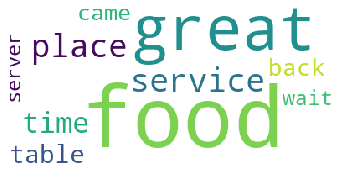

In [169]:
topic_k = 1
maxTermsPerTopic = 10

topics = loaded_model_lda.describeTopics(maxTermsPerTopic=maxTermsPerTopic)

toptopics = topics.select((topics.topic + 1).alias('topic'),
                          ListOfIndexToWords(topics.termIndices).alias('words'),
                          FormatNumbers(topics.termWeights).alias('weights'))

words = toptopics.collect()[topic_k-1][1]

frequencies = toptopics.collect()[topic_k-1][2]

d = {}
for i in range(len(words)):
    d[words[i]] = frequencies[i]
    
wordcloud = WordCloud(background_color="white",
                      max_font_size=100,relative_scaling=0.5,margin=5,
                      random_state=1, stopwords=None).generate_from_frequencies(d)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()